<a href="https://colab.research.google.com/github/G0nkly/pytorch_sandbox/blob/main/mlp/AK_MM_Part3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn.functional as F
%matplotlib inline

In [ ]:
# Import the library to mount Google Drive
from google.colab import drive
# Mount the Google Drive at /content/drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
words = open("/content/drive/MyDrive/Data/AK/names.txt", "r").read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [ ]:
# itos / stoi
chars = sorted(list(set("".join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi["."] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [ ]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + ".":
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y


import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [ ]:
# MLP revisited
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) *(5/3)/(n_embd * block_size)**0.5
# b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

# parameters = [C, W1, b1, W2, b2, bngain, bnbias]
parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))

for p in parameters:
  p.requires_grad = True

12097


In [ ]:
# same optimizations as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  # minibatch_construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  hpreact = embcat @ W1 #+ b1 # hidden layer preactivation
  # Batchnorm layer
  #----------------------------------------
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias

  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  #----------------------------------------

  # Non-linearity
  #----------------------------------------
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 10000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
  lossi.append(loss.log10().item())

      0/ 200000: 3.3239
  10000/ 200000: 2.0322


KeyboardInterrupt: 

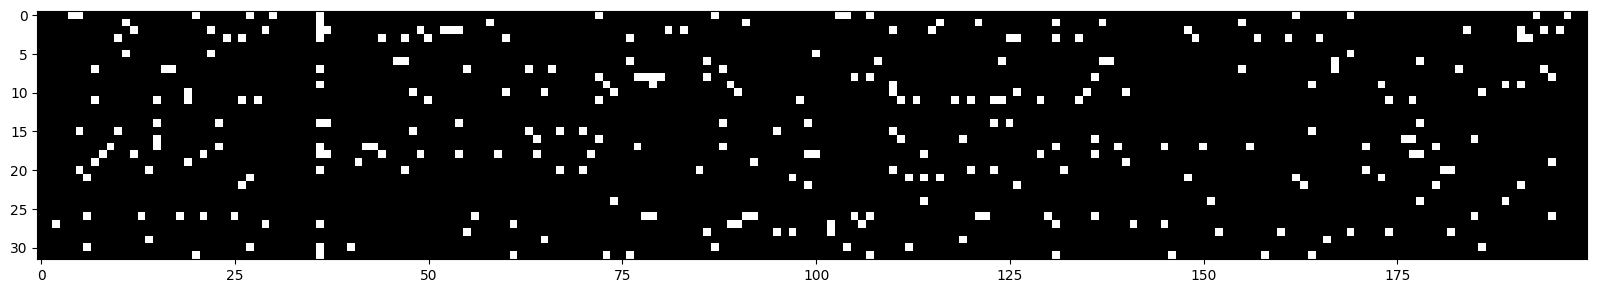

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap="gray", interpolation="nearest")

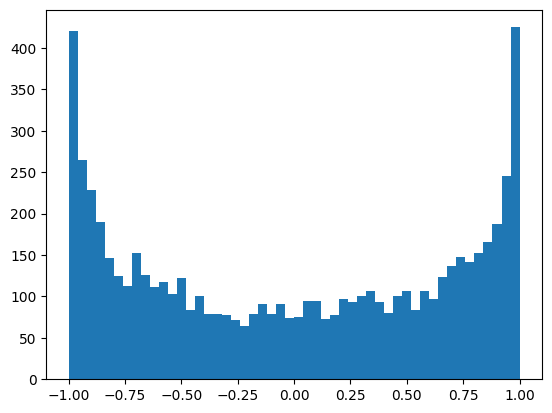

In [ ]:
plt.hist(h.view(-1).tolist(), 50);

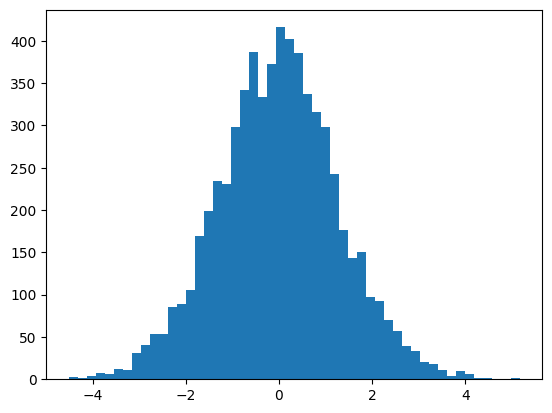

In [ ]:
plt.hist(hpreact.view(-1).tolist(), 50);

In [ ]:
logits[0]

tensor([ 2.2035, -0.5373, -0.5011,  0.9780, -0.4072,  1.5789, -1.2660, -0.8512,
        -1.4742, -0.1693, -0.6282, -0.7163,  1.3322,  0.3541,  1.1694, -0.6193,
        -0.8731, -1.3777,  0.0334,  2.2678,  0.2704, -0.2239,  0.7281, -0.3848,
         0.2402,  0.2365, -1.2202], grad_fn=<SelectBackward0>)

In [ ]:
-torch.tensor(1/27.0).log()

tensor(3.2958)

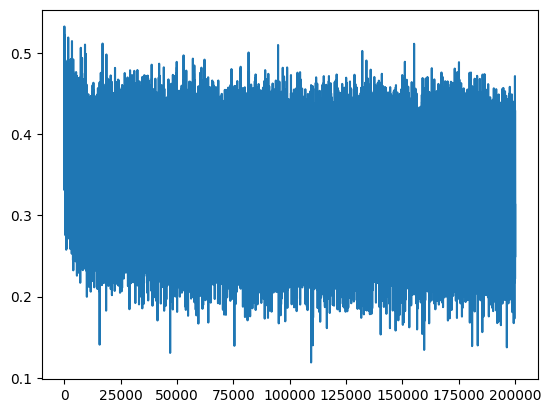

In [ ]:
import matplotlib.pyplot as plt
plt.plot(lossi)

In [ ]:
bnmean_running

tensor([[-1.4034,  0.2792, -1.1248,  1.0187,  0.8550,  0.2762,  1.0766, -1.2549,
          0.3071,  1.2580, -1.3043, -1.4612, -0.3050, -0.3949, -0.1498,  0.1040,
          0.4133, -1.6688, -0.3946,  1.0050,  0.3661, -0.3697, -0.1864,  0.5919,
          0.7165,  0.8269,  0.6174, -0.0145,  0.0824,  1.0240, -0.3162, -0.6488,
          0.1766,  0.0760, -0.3406, -1.0051, -1.4823,  0.0316, -0.1851,  0.3998,
         -0.0298, -0.8096, -0.4818,  0.1244,  0.8317,  0.3829,  0.6552, -0.0692,
          1.1708,  1.2241,  0.9411, -0.0918,  1.0155,  0.9073,  0.9386, -0.8785,
         -0.2941,  0.4335,  1.2893, -0.9590, -0.4917,  0.4018,  0.3697,  0.0856,
          1.2246,  1.0694, -0.4053,  0.8591, -0.4723, -0.0747, -0.2041,  0.7097,
          0.4126, -1.0822, -1.7170,  0.0701,  0.6344,  0.0649,  0.1234,  0.3958,
          0.6825,  1.0800,  0.9090,  0.3887,  0.2016, -0.2080, -0.9752,  0.3478,
          0.4371, -0.4828, -0.3947,  0.7433, -0.2720, -0.2419, -0.4321,  0.1769,
         -0.5064, -0.1390,  

In [ ]:
@torch.no_grad()
def split_loss(split):
  x,y = {
      "train": (Xtr, Ytr),
      "val": (Xdev, Ydev),
      "test": (Xte, Yte)
  }[split]
  emb = C[x] # (N, block_size, n_emb)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 #+ b1
  hpreact = bngain * (hpreact - bnmean_running) /bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, hidden)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss("train")
split_loss("val")

NameError: name 'b1' is not defined

In [ ]:
# Sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
  out = []
  context = [0] * block_size
  while True:
    # forward pass the neural net
    emb = C[torch.tensor([context])]
    h = torch.tanh(emb.view(1, -1) @ W1) #+ b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break

  print("".join(itos[i] for i in out))

NameError: name 'b1' is not defined

In [ ]:
# 4-dimensional example of the issue
logits = torch.tensor([-3.0,5.0,0.0,2.0])
logits = torch.randn(4)
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
logits, probs, loss

(tensor([-1.4445,  0.0887, -0.1767,  0.2365]),
 tensor([0.0687, 0.3183, 0.2441, 0.3690]),
 tensor(1.4103))

tensor(-0.0010) tensor(0.9966)
tensor(-0.0043) tensor(0.9806)


(array([2.31986025e-05, 4.63972051e-05, 4.63972051e-05, 0.00000000e+00,
        2.31986025e-05, 1.39191615e-04, 2.08787423e-04, 4.87170653e-04,
        8.35149692e-04, 1.32232035e-03, 2.52864768e-03, 3.24780436e-03,
        5.96204085e-03, 9.02425639e-03, 1.45919210e-02, 2.26882333e-02,
        3.44731234e-02, 5.35191761e-02, 7.55114513e-02, 1.10773327e-01,
        1.48285467e-01, 2.03080567e-01, 2.64556863e-01, 3.25337202e-01,
        3.80897855e-01, 4.20590664e-01, 4.35159387e-01, 4.23420894e-01,
        3.90014906e-01, 3.30788874e-01, 2.71238061e-01, 2.08601834e-01,
        1.57541710e-01, 1.14067529e-01, 7.94320151e-02, 5.33335873e-02,
        3.53314717e-02, 2.21778640e-02, 1.51718861e-02, 1.01145907e-02,
        6.28682129e-03, 3.78137222e-03, 1.92548401e-03, 1.20632733e-03,
        7.19156679e-04, 5.33567859e-04, 3.71177641e-04, 1.62390218e-04,
        6.95958076e-05, 6.95958076e-05]),
 array([-5.72633123, -5.51080101, -5.29527079, -5.07974056, -4.86421034,
        -4.64868011, 

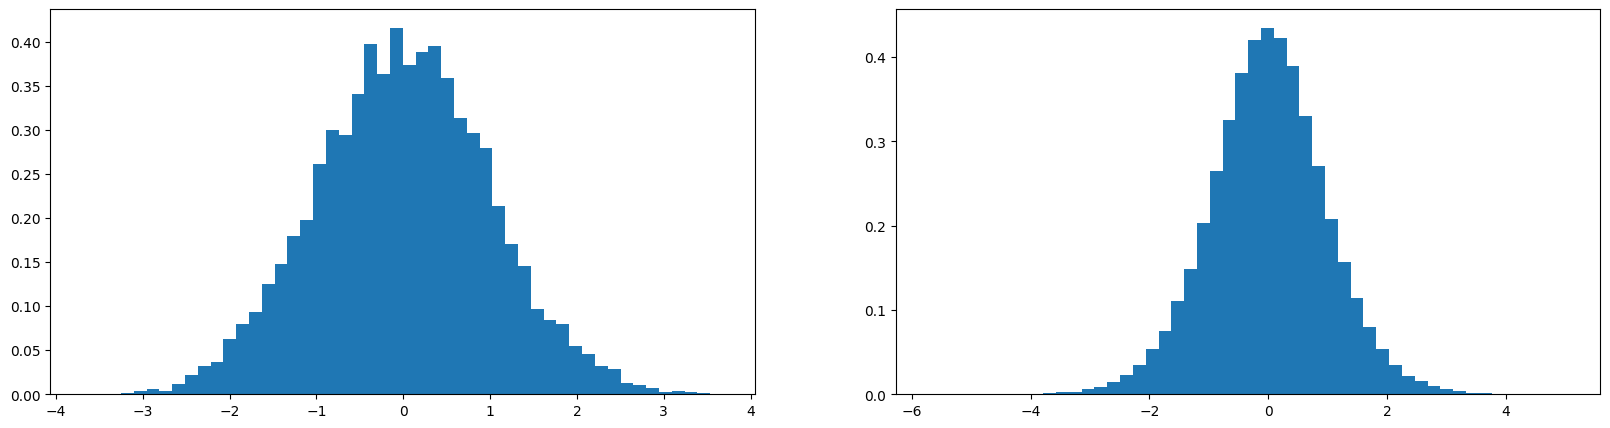

In [ ]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10**0.5
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)

In [ ]:
(torch.randn(1000) * 0.2).std()

tensor(0.1994)

In [ ]:
(5/3) / (30**0.5)

0.3042903097250923

In [ ]:
class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

class Batchnorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean =x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x-xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out

  def parameters(self):
    return []

n_embd = 10 # the dimensionalit of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden),  Batchnorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Batchnorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Batchnorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Batchnorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Batchnorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size), Batchnorm1d(vocab_size)
]

with torch.no_grad():
  # last layer: make less confident
  #layers[-1].weight *= 0.1
  layers[-1].gamma *= 0.1

  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True




47551


In [ ]:
# same optimizations as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

  # forward pass
  emb = C[Xb]
  x = emb.view(emb.shape[0], -1) # embed the characters into vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function

  # backward pass
  for layer in layers:
   layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learnig rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
  lossi.append(loss.log10().item())

  with torch.no_grad():
    ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break # AFTER_DEBUG: would take out obviously to run full optimization


      0/ 200000: 3.2870


layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.62%
layer 5 (      Tanh): mean +0.00, std 0.64, saturated: 2.47%
layer 8 (      Tanh): mean -0.00, std 0.64, saturated: 2.16%
layer 11 (      Tanh): mean +0.00, std 0.65, saturated: 1.81%
layer 14 (      Tanh): mean -0.00, std 0.65, saturated: 1.78%


Text(0.5, 1.0, 'activation distribution')

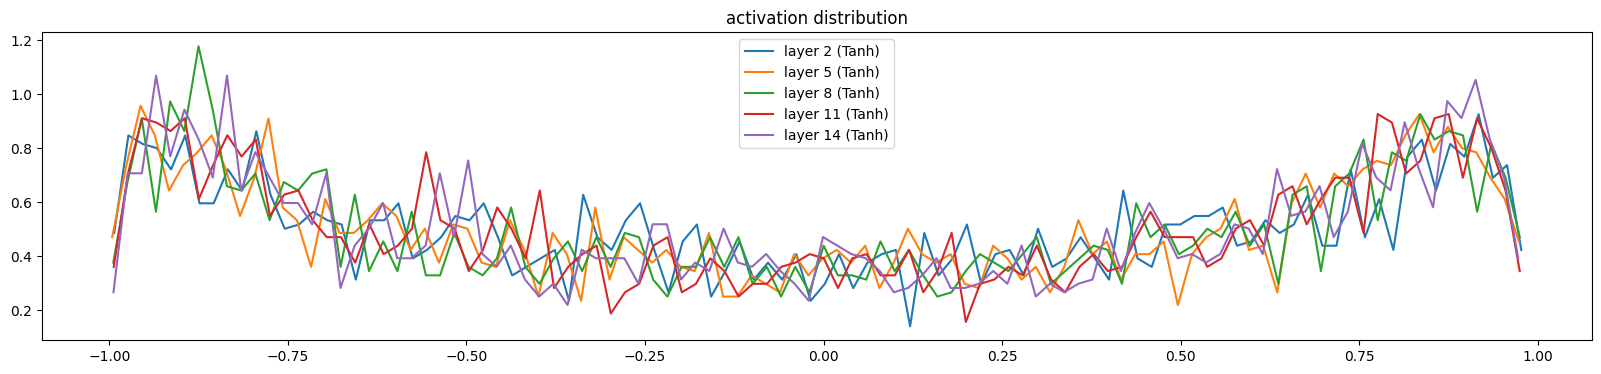

In [ ]:
# visaulize histograms
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print("layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%" % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f"layer {i} ({layer.__class__.__name__})")
plt.legend(legends)
plt.title("activation distribution")

layer 2 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%
layer 5 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%
layer 8 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 11 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 14 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%


Text(0.5, 1.0, 'activation distribution')

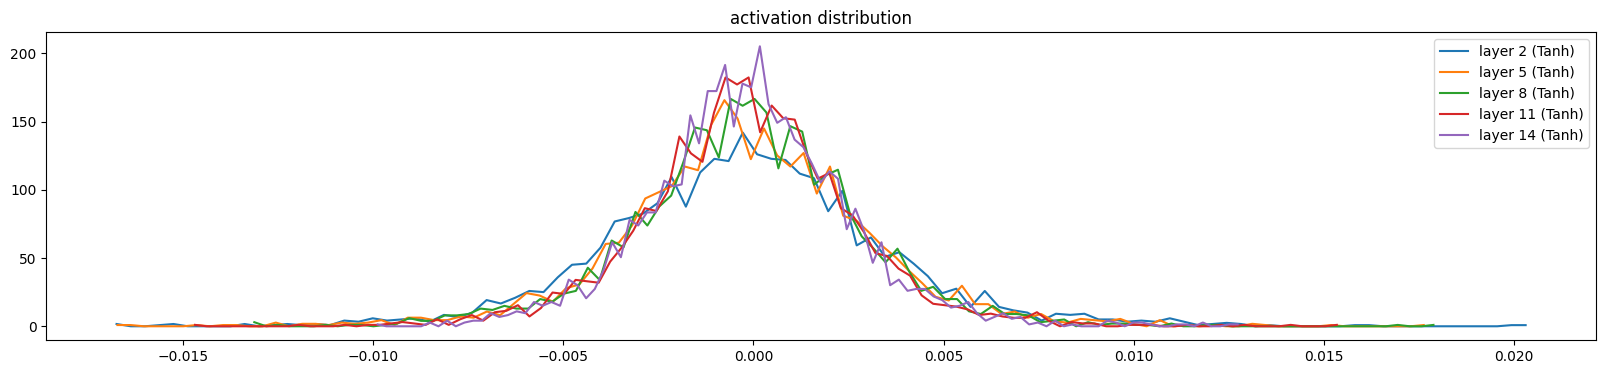

In [ ]:
# visaulize histograms
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print("layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%" % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f"layer {i} ({layer.__class__.__name__})")
plt.legend(legends)
plt.title("activation distribution")

weight   (27, 10) | mean 0.000000 | std 1.019890e-02 | grad:data ratio 1.018851e-02
weight  (30, 100) | mean 0.000092 | std 8.238448e-03 | grad:data ratio 2.635845e-02
weight (100, 100) | mean 0.000031 | std 7.318127e-03 | grad:data ratio 4.377153e-02
weight (100, 100) | mean -0.000019 | std 6.662029e-03 | grad:data ratio 3.949899e-02
weight (100, 100) | mean -0.000019 | std 5.821521e-03 | grad:data ratio 3.468164e-02
weight (100, 100) | mean 0.000053 | std 5.445303e-03 | grad:data ratio 3.243371e-02
weight  (100, 27) | mean -0.000165 | std 1.046846e-02 | grad:data ratio 6.281275e-02


Text(0.5, 1.0, 'activation distribution')

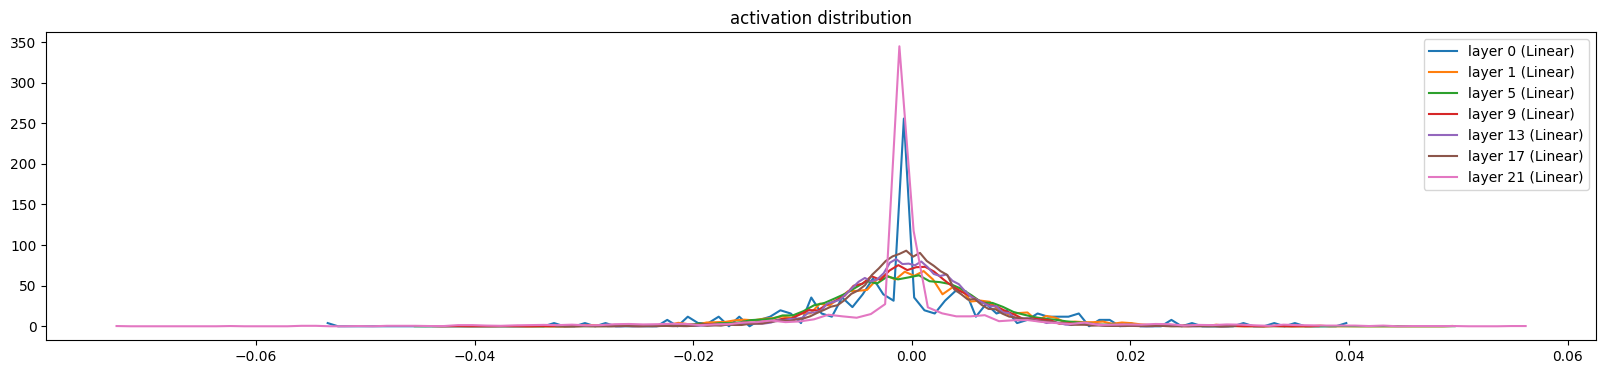

In [ ]:
# visaulize histograms
plt.figure(figsize=(20,4))
legends = []
for i,p in enumerate(parameters): # note: exclude the output layer
  t = p.grad
  if p.ndim == 2:
    print("weight %10s | mean %f | std %e | grad:data ratio %e" % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f"layer {i} ({layer.__class__.__name__})")
plt.legend(legends)
plt.title("activation distribution")

Text(0.5, 1.0, 'activation distribution')

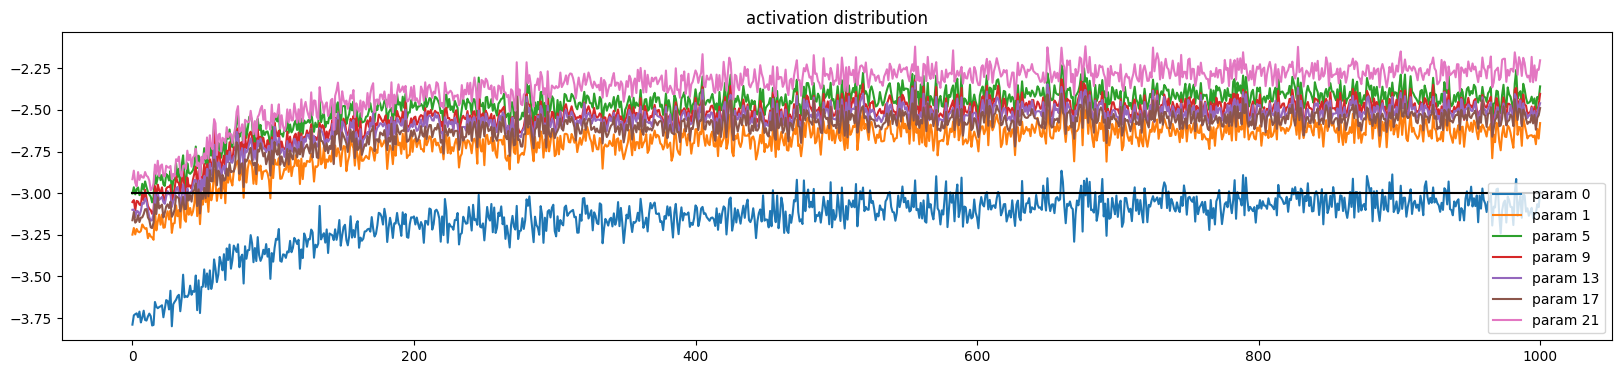

In [ ]:
# visaulize histograms
plt.figure(figsize=(20,4))
legends = []
for i,p in enumerate(parameters): # note: exclude the output layer
  if p.ndim == 2:
    ls = [ud[j][i] for j in range(len(ud))]
    plt.plot(ls)
    legends.append("param %d" % i)
plt.plot([0, len(ud)], [-3,-3], "k") # these ratios should be ~1e-3, indicate on plot
plt.legend(legends)
plt.title("activation distribution")